<a href="https://colab.research.google.com/github/xr-cc/proj-hsg-env-chal/blob/master/code/clustering_CES3_targetCES3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering analysis of CES3 Bay Area data

In [25]:
! pip install geopandas
! pip install descartes
! pip install mapclassify
! pip install libpysal
! pip install esda

     |████████████████████████████████| 972kB 5.3MB/s 
     |████████████████████████████████| 10.9MB 26.1MB/s 
     |████████████████████████████████| 14.8MB 323kB/s 
     |████████████████████████████████| 2.4MB 5.2MB/s 
  Created wheel for libpysal: filename=libpysal-4.3.0-py2.py3-none-any.whl size=2379082 sha256=231629bbeab3c6b80f147b07a9c97f43aedba063f810132a317a85a111b5465d
  Stored in directory: /root/.cache/pip/wheels/68/44/db/3d7a8b7d9ae5dba0cfcfb37f14e2a6e6f26b03557bdf1cf06d
Successfully built libpysal
     |████████████████████████████████| 71kB 2.9MB/s 
  Created wheel for esda: filename=esda-2.3.1-cp36-none-any.whl size=82452 sha256=8637c40219af7dd16bf4875575dc27c21a08a85469b78eaaa24826dcce1d5899
  Stored in directory: /root/.cache/pip/wheels/0f/7e/49/fe3abdfe85019a1390c7bf70af56275139fa7f99a57ff5333f
Successfully built esda


In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy as np
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable


import mapclassify as mc
import libpysal as lps
from esda.moran import Moran,Moran_Local

from matplotlib import colors

import numpy as np
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn import metrics


In [2]:
# grant access to Google Drive
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [140]:
from google.colab import files

In [3]:
# load data

dataPath = "/content/drive/My Drive/DS4A/DS4A_Team 31/data/CES3/"
xls = pd.ExcelFile(dataPath+"CES3, income brackets, seismic - Bay Area.xlsx")
sheets = xls.sheet_names
print(sheets)


['CES 3.0 (2018 Update)', 'Income cutoffs per county', 'Data Dictionary', 'Missing&NAData', 'Demographic profile']


In [84]:
# load dataframes

df = pd.read_excel(xls, sheet_name=sheets[0])
df_dict = pd.read_excel(xls, sheet_name=sheets[2],skiprows=range(0,6)).dropna(thresh=2)
df_demo = pd.read_excel(xls, sheet_name=sheets[4], header=None,
                        names=['Census Tract','CES 3.0 Score','CES 3.0 Percentile','CES 3.0 Percentile Range','Total Population',
                               'California County','Age:<10','Age:11-64','Age:>65', 'Race:Hispanic','Race:White','Race:AfricanAmerican',
                               'Race:NativeAmerican','Race:Aisan','Race:Other'],skiprows=[0]).dropna()

df_dict_temp = df_dict.dropna()
pop_char = df_dict_temp[df_dict_temp['CalEnviroScreen Category'].str.contains('Population') & 
                        ~df_dict_temp['Variable Name'].str.contains('Pctl')]['Variable Name'].drop_duplicates()

pop_char = [v.rstrip() for v in pop_char]
env_char = df_dict_temp[df_dict_temp['CalEnviroScreen Category'].str.contains('Pollution') & 
                        ~df_dict_temp['Variable Name'].str.contains('Pctl')]['Variable Name'].drop_duplicates()
env_char = [v.rstrip() for v in env_char]
income_char = df.columns[1:10]
# var_char.insert(0,'Census ID')
print(pop_char)
print(env_char)
print(income_char)

['Asthma', 'Low Birth Weight', 'Cardiovascular Disease', 'Education', 'Linguistic Isolation', 'Poverty', 'Unemployment', 'Housing Burden']
['Ozone', 'PM2.5', 'Diesel PM', 'Drinking Water', 'Pesticides', 'Tox. Release', 'Traffic', 'Cleanup Sites', 'Groundwater Threats', 'Haz. Waste', 'Imp. Water Bodies', 'Solid Waste']
Index(['INDEPENDENT BRACKET: Less than $25,000 household income',
       '$25,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999',
       '$100,000 or More',
       'CUMULATIVE: Percentage of households with income Less than $50,000',
       'Less than $60,000', 'Less than $75,000', 'Less than $100,000'],
      dtype='object')


In [85]:
# load geo dataframe
gdf = gpd.read_file(dataPath+"CES3June2018Update.shp")
gdf = gdf[gdf['tract'].isin(df['Census ID'])].reset_index(drop=True).rename(columns={'tract': 'Census ID'})

# join dataframes
geo_cols = ['Census ID','OBJECTID_1', 'CIdecile', 'CIvigintil', 'Shape_Leng', 'Shape_Area','CES2018_Rn', 'geometry']
gdf = gdf[geo_cols]
gdf = gdf.merge(df, on='Census ID')
gdf.head()
# gdf.columns

,Census ID,OBJECTID_1,CIdecile,CIvigintil,Shape_Leng,Shape_Area,CES2018_Rn,geometry,County,"INDEPENDENT BRACKET: Less than $25,000 household income","$25,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 or More","CUMULATIVE: Percentage of households with income Less than $50,000","Less than $60,000","Less than $75,000","Less than $100,000",Census Tract,Total Population,Unnamed: 13,California County,ZIP,Nearby City \n(to help approximate location only),SEISMIC PGA,Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,SB 535 Disadvantaged Community,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6.085509e+09,5110,4,8,5862.187357,1.581581e+06,35-40%,"POLYGON ((-182852.281 -67226.673, -182870.875 ...",Santa Clara,6.2,12.8,9.0,9.7,62.4,19.0,23.1,28.0,37.6,5092.01,4603,NaN,Santa Clara,94043,Mountain View,NaN,-122.074346,37.401206,19.894588,38.050195,35-40%,No,0.035258,16.938395,9.955483,42.864271,28.579835,82.787803,277.402571,28.701509,0.000000,0.000000,252.024338,40.296832,1230.83,76.212558,66.5,97.756293,121.85,98.013903,0.200,60.500463,5,55.007738,0.0,0.0,48.161547,5.932202,67.330429,20.70,8.839297,4.77,45.802896,6.48,30.270540,5.0,19.707292,4.6,33.902146,10.5,7.806411,9.9,55.298896,21.5,65.143437,32.337940,3.353660,23.054610
1,6.085510e+09,7893,1,1,7610.538985,2.592144e+06,1-5% (lowest scores),"POLYGON ((-186882.009 -66430.601, -186916.298 ...",Santa Clara,5.0,5.7,8.4,5.8,75.1,10.7,13.9,19.1,24.9,5105.00,4688,NaN,Santa Clara,94022,Los Altos,NaN,-122.120112,37.392783,3.534646,1.412536,1-5% (lowest scores),No,0.035258,16.938395,9.955483,42.864271,19.895047,61.219664,465.266900,47.561432,0.055507,16.412742,202.201348,36.118733,566.07,37.974684,6.9,50.474279,17.10,65.921880,0.060,28.044486,0,0.000000,0.0,0.0,34.304607,4.225401,30.105787,9.01,0.423887,2.63,5.549148,3.43,1.882558,2.4,7.418622,2.2,15.677910,5.8,1.759899,3.5,4.251809,15.7,38.461538,8.066243,0.836523,0.731492
2,6.085509e+09,7475,1,2,3401.365567,6.661267e+05,5-10%,"POLYGON ((-186342.464 -65548.645, -186507.620 ...",Santa Clara,14.4,6.4,12.8,16.8,49.7,20.8,26.3,33.6,50.4,5094.01,3212,NaN,Santa Clara,94306,Palo Alto,NaN,-122.114454,37.406981,7.973068,8.374322,5-10%,No,0.035258,16.938395,9.536303,40.918164,23.860000,72.980709,491.909027,52.276413,0.000000,0.000000,205.502860,36.530307,633.51,44.742449,5.3,45.220722,16.50,64.581264,0.000,0.000000,0,0.000000,0.0,0.0,32.499793,4.003097,25.550716,9.79,0.610896,3.75,20.889402,3.16,1.009849,3.8,14.042392,13.4,70.590588,15.2,16.668762,5.2,14.151542,15.8,39.083524,19.205372,1.991725,7.478875
3,6.085509e+09,5496,4,7,3211.309410,5.758547e+05,30-35%,"POLYGON ((-184858.846 -66420.547, -185397.071 ...",Santa Clara,17.6,13.5,12.5,8.9,47.5,31.1,32.6,43.6,52.5,5093.03,3706,NaN,Santa Clara,94043,Mountain View,NaN,-122.092278,37.406030,17.198943,30.836171,30-35%,No,0.035258,16.938395,9.536303,40.918164,23.860000,72.980709,277.402571,28.701509,0.000000,0.000000,225.063625,38.600649,493.52,30.078957,44.2,95.147756,30.85,82.224429,0.025,15.681186,4,48.795048,0.0,0.0,37.858312,4.663122,39.439950,21.29,9.712006,3.85,22.952710,6.69,33.038275,10.4,40.625789,19.7,83.922144,29.3,43.570082,7.3,32.097982,17.1,45.925362,35.564634,3.688290,27.922815
4,6.085503e+09,3123,7,13,5951.985625,1.670329e+06,60-65%,"POLYGON ((-160742.128 -73973.529, -160380.

In [86]:
# data cleaning: use both enviromental and population variables
sub_df = gdf[env_char+pop_char+geo_cols+['CES 3.0 Score']]
sub_df = sub_df.dropna()
y_df = sub_df['CES 3.0 Score']

X_df = sub_df[env_char+pop_char]
indices = sub_df.index.tolist()
print(len(X_df),"out of",len(df),"rows are valid data")

1507 out of 1581 rows are valid data


In [87]:
X = X_df.values
y = y_df.values
n, m = X.shape
print("n={},m={}".format(n,m))
print(y.shape)

n=1507,m=20
(1507,)


In [220]:

# Clutering methods:
n_cluster = 5
methods = {'kmeans':KMeans(n_clusters=n_cluster, random_state=0),
           'spectral': SpectralClustering(n_clusters=n_cluster,assign_labels="discretize",random_state=0), # not working
           'GMM':GaussianMixture(n_components=n_cluster),
           'agglomerative':AgglomerativeClustering(n_clusters=n_cluster,linkage='ward'),
           'DBSCAN':DBSCAN(eps=2, min_samples=10)}


### Clustering on the entire set (no train-test split)


In [197]:
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=5, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent], 
                          width / self.num_stripes, 
                          height, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

In [211]:
# standardizing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
print(X.shape)

(1507, 20)


In [218]:
method = 'kmeans'
clustering = methods[method].fit(X_scaled)
y_clustered = clustering.labels_
print(np.unique(y_clustered))

[0 1 2 3 4]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

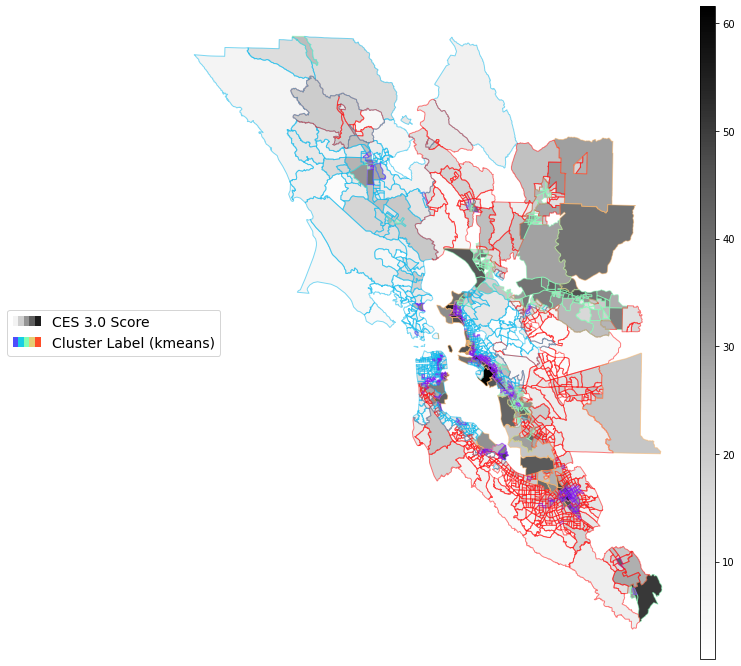

In [221]:


# plot clustering results for data spatially

target = 'CES 3.0 Score'
f, ax = plt.subplots(figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)


sub_df['cluster'] = y_clustered
result_df = sub_df[['cluster']+geo_cols]
items = [sub_df.plot(ax=ax, cax=cax, column=target, cmap='Greys', legend=True, figsize=(8,8)),
         result_df.plot(ax=ax, cax=cax, column='cluster', cmap='rainbow', alpha=0.5, facecolor="none",edgecolor="black", linewidth=1)]#,facecolor="none", edgecolor="black", markersize=5)]

# ax.legend(items, ['Score', 'Cluster'])

# ax.set_title("{}".format(target),fontsize=18)
ax.set_axis_off()
ax.set_aspect('equal')

var = 'CES 3.0 Score'
cmaps = [plt.cm.Greys, plt.cm.rainbow] 
cmap_labels = [var, "Cluster Label ({})".format(method)]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=len(np.unique(y_clustered))) for cm in cmaps]))
f.legend(handles=cmap_handles,  labels=cmap_labels,  handler_map=handler_map, loc="center left", fontsize=14)


plt.savefig("{}_cluster_{}.png".format(var,method),bbox_inches='tight', )
files.download("{}_cluster_{}.png".format(var,method))

### Train algorithm and test clustering on different data

In [10]:
X_train, X_test, indices_train, indices_test = train_test_split(X, indices, test_size=0.2, random_state=42)
print("Train size",X_train.shape)
print("Test size",X_test.shape)

# standardizing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

Train size (1205, 39)
Test size (302, 39)
